
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lyeskhalil/mlbootcamp2022/blob/main/lab_4_2_rnn.ipynb)

# UofT FASE ML Bootcamp
#### Thursday June 16, 2022
#### Reccurrent Neural Networks - Lab 2, Day 4 
#### Teaching team: Elias Khalil, Alex Olson, Rahul Patel, and Jake Mosseri
##### Lab author: Jake Mosseri




Adapted from:

NLP From Scratch: Classifying Names with a Character-Level RNN
**************************************************************
 `Sean Robertson <https://github.com/spro/practical-pytorch>`_


We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


First you will need to download the data from the github using the code below, which accesses our github and downloads and unzips the names folder. Make sure you can see a folder called names in the files section of colab after you run the following block.

In [2]:
from pathlib import Path
from os import system

if not Path('names.zip').exists():
  system('wget --no-check-certificate --content-disposition https://github.com/lyeskhalil/mlbootcamp2022/raw/main/names.zip')

if not Path('names').exists():
  system('unzip names.zip')

In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
from sklearn.model_selection import train_test_split
%matplotlib inline

def findFiles(path): return glob.glob(path)

print(findFiles('names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
test_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    train, test = train_test_split(lines)

    category_lines[category] = train
    test_lines[category] = test


n_categories = len(all_categories)

['names/Greek.txt', 'names/French.txt', 'names/Italian.txt', 'names/Vietnamese.txt', 'names/Dutch.txt', 'names/Chinese.txt', 'names/Spanish.txt', 'names/Arabic.txt', 'names/Korean.txt', 'names/Czech.txt', 'names/German.txt', 'names/Russian.txt', 'names/Irish.txt', 'names/Japanese.txt', 'names/Portuguese.txt', 'names/Polish.txt', 'names/English.txt', 'names/Scottish.txt']
Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [4]:
print(category_lines['Italian'][:5])

['Vaccaro', 'Stabile', 'Provenza', "D'ambrosio", 'Nardo']


Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.



**YOUR TURN:** In the code below, we differentiate between an upper case and a lower case letter (i.e., the letter "J" and the letter "j" will produce two different vectors). 
* Can you think of reasons why this may or may not be wanted behaviour (for this use case or others)?____________________________



In [8]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.





In [9]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = F.log_softmax(output, dim=1)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

**YOUR TURN:** In the code below, fill out an LSTM version of the neural net by using the nn.LSTM pytorch function instead of the two linear layers that we used above.
* Look into the documentation for nn.LSTM to play around with different hyperparameters. If you want, you could try to stack multiple LSTM layers (by changing a hyperparameter) and observe its performance.

In [10]:
class LSTM(nn.Module):

    def __init__(self, n_hidden, n_letters, n_categories):
        super(LSTM, self).__init__()
        # The LSTM takes letter vectors as inputs, and outputs hidden states
        # with dimensionality n_hidden.
        self.lstm = nn.LSTM(n_letters, n_hidden)

        # The linear layer that maps from hidden state space to language space
        self.hidden2lang = nn.Linear(n_hidden, n_categories)

    def forward(self, letter, hidden=None):
        # Insert your code here

    def initHidden(self):
        return


lstm = LSTM(n_hidden, n_letters, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). For the LSTM network, if we pass in nothing for the hidden state, it will automatically initialzie the first hidden state and cell as zeros. We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [11]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)
output, next_hidden = lstm(input)
print(output)

tensor([[-2.9386, -3.0144, -3.0032, -2.7627, -2.8576, -2.8801, -2.8819, -2.8498,
         -2.8386, -2.9768, -2.8599, -2.8989, -2.8158, -2.8669, -2.9292, -2.9381,
         -2.8899, -2.8601]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-2.9286, -2.9284, -2.8745, -2.8442, -2.8579, -2.9728, -2.8285, -2.8571,
         -2.8605, -2.9562, -2.9088, -2.8308, -2.9213, -2.8812, -2.9297, -2.8717,
         -2.8579, -2.9333]], grad_fn=<LogSoftmaxBackward0>)


For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [12]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

output, next_hidden = lstm(input[0])
print(output)

tensor([[-2.9386, -3.0144, -3.0032, -2.7627, -2.8576, -2.8801, -2.8819, -2.8498,
         -2.8386, -2.9768, -2.8599, -2.8989, -2.8158, -2.8669, -2.9292, -2.9381,
         -2.8899, -2.8601]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-2.9286, -2.9284, -2.8745, -2.8442, -2.8579, -2.9728, -2.8285, -2.8571,
         -2.8605, -2.9562, -2.9088, -2.8308, -2.9213, -2.8812, -2.9297, -2.8717,
         -2.8579, -2.9333]], grad_fn=<LogSoftmaxBackward0>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [13]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Spanish', 6)


We will also want a quick way to get a training example (a name and its
language):




In [14]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

def randomTestingExample():
    category = randomChoice(all_categories)
    line = randomChoice(test_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Chinese / line = Guan
category = Korean / line = Cho
category = Portuguese / line = Souza
category = German / line = Stauss
category = Arabic / line = Gerges
category = Dutch / line = Rompaeij
category = English / line = Trainor
category = Arabic / line = Shamon
category = Greek / line = Dioletis
category = Scottish / line = Graham


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [15]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [16]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor, model):
    hidden = model.initHidden()

    model.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    # This is manually updating the weights similarly to how it was described in the 3 blue 1 brown video yesterday
    for p in model.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [17]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

model_to_train = lstm



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor, model_to_train)


    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 16s) 2.9162 Cao / Italian ✗ (Vietnamese)
10000 10% (0m 34s) 2.9186 Bazzi / Italian ✗ (Arabic)
15000 15% (0m 50s) 2.7934 Cong / Vietnamese ✗ (Chinese)
20000 20% (1m 7s) 2.7581 Uhlik / Polish ✗ (Czech)
25000 25% (1m 24s) 2.5876 Toma / Chinese ✗ (Arabic)
30000 30% (1m 40s) 2.6207 Moreno / French ✗ (Portuguese)
35000 35% (1m 57s) 2.7440 Keefe / German ✗ (Irish)
40000 40% (2m 13s) 2.3429 Horri / Italian ✗ (Japanese)
45000 45% (2m 30s) 1.4474 Zinovin / Russian ✓
50000 50% (2m 47s) 0.6579 Nishikawa / Japanese ✓
55000 55% (3m 4s) 1.5988 Essa / Arabic ✓
60000 60% (3m 20s) 1.3635 Kalaev / Russian ✓
65000 65% (3m 36s) 0.7192 Kouros / Greek ✓
70000 70% (3m 53s) 3.1748 Casey / Arabic ✗ (Irish)
75000 75% (4m 9s) 0.0487 Jachmentsev / Russian ✓
80000 80% (4m 26s) 1.3196 Sheehy / Irish ✓
85000 85% (4m 44s) 1.7066 Kunze / German ✓
90000 90% (5m 1s) 1.2417 Jeong / Chinese ✗ (Korean)
95000 95% (5m 18s) 0.4949 Janicek / Czech ✓
100000 100% (5m 34s) 1.1969 Naifeh / Irish ✗ (Arabic)


Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




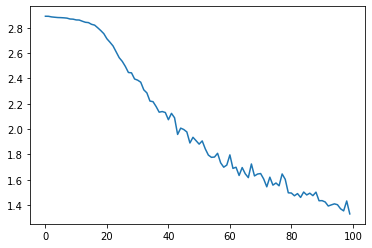

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




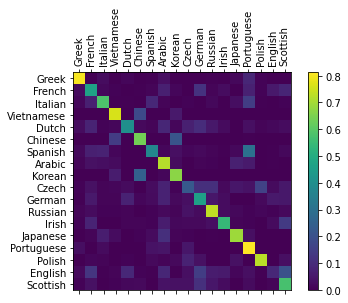

In [19]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

model_to_evaluate = lstm

# Just return an output given a line
def evaluate(line_tensor, model):
    hidden = model.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor, model_to_evaluate)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages as these are anglicized versions of the last names anyhow).




**YOUR TURN:** 
* When splitting the data into training, validation, and testing, what is something that you should consider about which data goes into each of these sets? ___________________________
* Consider the metric of accuracy, which just scores correct predicitons / total predictions. Why is this metric not ideal for multiclass classification problems like this one? ___________________________
* The data provided happened to have a pretty equal balance of names for each class. If the dataset is imbalanced, what do you think are appropriate ways to handle this? __________ If nothing is done to handle this, the model could achieve a very high accuracy. Why would this be the case, and would the high accuracy imply that the model is "good"? ___________
* Try predicting on a random sequence of letters. Is the model confident about its response? How much do you think that this matters?
* Try running the confusion matrix on our validation set and see how it differs!

In [ ]:
#Insert test confusion matrix code here

Running on User Input
---------------------




In [ ]:
def predict(input_line, model, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line), model)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky', lstm)
predict('Jackson', lstm)
predict('Satoshi', lstm)

predict('Dovesky', rnn)
predict('Jackson', rnn)
predict('Satoshi', rnn)


> Dovesky
(-0.50) Russian
(-1.76) Czech
(-2.41) Polish

> Jackson
(-0.49) Scottish
(-1.90) English
(-2.92) Dutch

> Satoshi
(-0.48) Japanese
(-1.19) Arabic
(-3.15) Italian

> Dovesky
(-2.81) Russian
(-2.84) Spanish
(-2.84) Italian

> Jackson
(-2.78) Scottish
(-2.79) Italian
(-2.81) Vietnamese

> Satoshi
(-2.78) Vietnamese
(-2.79) Arabic
(-2.79) Portuguese
